In [11]:
#!/usr/bin/env python3
import os
import re
import sys
import collections
import argparse
import tables
import glob
import itertools
import math

import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.sparse as sp_sparse

from multiprocessing import Pool
from collections import defaultdict
from scipy import sparse, io
from scipy.sparse import csr_matrix
from multiprocessing import Pool

import matplotlib.pyplot as plt
import networkx as nx
import pycircos
Garc    = pycircos.Garc
Gcircle = pycircos.Gcircle

## Load data
___

In [12]:
length_list = [0, 248956422, 491149951, 689445510, 879660065, 1061198324,
               1232004303, 1391350276, 1536488912, 1674883629, 1808681051,
               1943767673, 2077042982, 2191407310, 2298451028, 2400442217,
               2490780562, 2574038003, 2654411288, 2713028904, 2777473071,
               2824183054, 2875001522, 3031042417]

chr_order = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
             '12', '13', '14', '15', '16', '17', '18', '19', '20',
             '21', '22', 'X', 'Y']

v2_FILE = '/project/GCRB/Hon_lab/shared/former_members/s160875/03.analysis/Mosaic-seq/CROP-DE-analysis_10X-66K_no_downsampling-CPM.hg38/\
combine_10sgRNAs-volcano/generate_annotations/plot_annotation.txt'

annot_df = pd.read_csv(v2_FILE,
        header = None,
        sep='\t',
        names = ['idx', 'gene_names', 'chromosome', 'pos', 'strand', 'color_idx', 'chr_idx'])

In [13]:
local_columns = [
        'idx', 'gene_names', 'chromosome', 'pos', 'strand', 
        'color_idx', 'chr_idx', 'region', 'distance', 'num_cell', 'bin', 
        'pval', 'fc', 'padj-Gaussian', 'fc_by_rand_dist_cpm']

In [15]:
MB361_local_df = pd.read_csv('./MB361-filter_local_df.csv')[local_columns]
MB231_local_df = pd.read_csv('./MB231-filter_local_df.csv')[local_columns]

In [16]:
print(MB361_local_df.shape)
print(MB231_local_df.shape)

(366, 15)
(335, 15)


## Build networks 
___

In [19]:
import networkx as nx
G361 = nx.DiGraph()
for r in np.unique(MB361_local_df.region.values):
    
    primary_genes = MB361_local_df.loc[MB361_local_df.region == r].gene_names.values
    G361.add_node(r, type='enhancer', color=0)
    G361.add_nodes_from(primary_genes, type='gene', color=1)
    
    #add edges
    for pg in primary_genes:
        G361.add_edge(r, pg, regulation='blue')


In [21]:
import networkx as nx
G231 = nx.DiGraph()
for r in np.unique(MB231_local_df.region.values):
    
    primary_genes = MB231_local_df.loc[MB231_local_df.region == r].gene_names.values
    G231.add_node(r, type='enhancer', color=0)
    G231.add_nodes_from(primary_genes, type='gene', color=1)
    
    #add edges
    for pg in primary_genes:
        G231.add_edge(r, pg, regulation='blue')

In [22]:
print(len(G361.nodes()))
print(len(G231.nodes()))

677
613


## Circos plot
___

In [23]:
chr_name = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 
            'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
            'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']

chr_length = [248956422, 242193529, 198295559, 190214555, 181538259, 170805979, 159345973, 145138636, 138394717, 133797422, 135086622,
              133275309, 114364328, 107043718, 101991189, 90338345, 83257441, 80373285, 58617616, 64444167, 46709983, 50818468, 156040895]

In [24]:
circle = Gcircle()
for name, length in zip(chr_name, chr_length):
    arc = Garc(arc_id=name, size=length, interspace=3, raxis_range=(880,930), labelposition=45, label_visible=False, facecolor='#FFFFFF')
    circle.add_garc(arc) 

<Figure size 576x576 with 0 Axes>

In [25]:
circle.set_garcs() 

## Add all the perturbation regions to the outer ring
____

In [26]:
# perturbation region 
sgrna_dict = {}
sgrnas_file = '/project/GCRB/Hon_lab/s426305/Sequencing_data_analysis/10X/MB231-GWAS_SM-combine/All_enhancer_regions_hg38.txt'
with open(sgrnas_file) as f:
    for line in f:
        region_id, sgrna_string = line.strip().split("\t")
        sgrnas = sgrna_string.split(";")
        sgrna_dict.update({region_id : sgrnas})

In [27]:
arcdata_dict = collections.defaultdict(dict)
for i in list(sgrna_dict.keys()):
    name = i.split(':')[0]
    start = int(i.split(':')[1].split('-')[0])
    end = int(i.split(':')[1].split('-')[1])
    width = end - start
    if name not in arcdata_dict:
        arcdata_dict[name]["positions"] = []
        arcdata_dict[name]["widths"]    = [] 
        arcdata_dict[name]['gene_names'] = []
        arcdata_dict[name]['colors'] = []
    arcdata_dict[name]["positions"].append(start) 
    arcdata_dict[name]["widths"].append(width*1000)
    arcdata_dict[name]["colors"].append('#7A68A6')

for key in arcdata_dict:
    circle.barplot(key, data=[1]*len(arcdata_dict[key]["positions"]), positions=arcdata_dict[key]["positions"], 
                   width=arcdata_dict[key]["widths"], raxis_range=[950, 1000], facecolor=arcdata_dict[key]["colors"], spine=True)

## Add MB361 enhancer line into the circle plot 
___

In [28]:
cutoff = 0
large_node_list = [n for n, d in G361.degree() if d > cutoff]

In [29]:
enh_node_list = list(set([i for i in G361.nodes() if i.startswith('chr')]).intersection(set(large_node_list)))

In [30]:
len(set([i for i in G361.nodes() if i.startswith('chr')]))

336

In [31]:
len(enh_node_list)

336

In [32]:
arcdata_dict = collections.defaultdict(dict)
for i in enh_node_list:
    name = i.split(':')[0]
    start = int(i.split(':')[1].split('-')[0])
    end = int(i.split(':')[1].split('-')[1])
    width = end - start
    if name not in arcdata_dict:
        arcdata_dict[name]["positions"] = []
        arcdata_dict[name]["widths"]    = [] 
        arcdata_dict[name]["colors"]    = [] 
    arcdata_dict[name]["positions"].append(start) 
    arcdata_dict[name]["widths"].append(width*1000) # increase the width to see the line on the plot 
    arcdata_dict[name]["colors"].append('#7A68A6')
        
for key in arcdata_dict:
    circle.barplot(key, data=[1]*len(arcdata_dict[key]["positions"]), positions=arcdata_dict[key]["positions"], 
                   width=arcdata_dict[key]["widths"], raxis_range=[880,930], facecolor=arcdata_dict[key]["colors"], spine=True)

## Add MB231 enhancer line into the circle plot 
___

In [33]:
cutoff = 0
large_node_list = [n for n, d in G231.degree() if d > cutoff]

In [34]:
enh_node_list = list(set([i for i in G231.nodes() if i.startswith('chr')]).intersection(set(large_node_list)))

In [35]:
len(set([i for i in G231.nodes() if i.startswith('chr')]))

303

In [36]:
len(enh_node_list)

303

In [37]:
arcdata_dict = collections.defaultdict(dict)
for i in enh_node_list:
    name = i.split(':')[0]
    start = int(i.split(':')[1].split('-')[0])
    end = int(i.split(':')[1].split('-')[1])
    width = end - start
    if name not in arcdata_dict:
        arcdata_dict[name]["positions"] = []
        arcdata_dict[name]["widths"]    = [] 
        arcdata_dict[name]["colors"]    = [] 
    arcdata_dict[name]["positions"].append(start) 
    arcdata_dict[name]["widths"].append(width*1000) # increase the width to see the line on the plot 
    arcdata_dict[name]["colors"].append('#7A68A6')
        
for key in arcdata_dict:
    circle.barplot(key, data=[1]*len(arcdata_dict[key]["positions"]), positions=arcdata_dict[key]["positions"], 
                   width=arcdata_dict[key]["widths"], raxis_range=[810,860], facecolor=arcdata_dict[key]["colors"], spine=True)

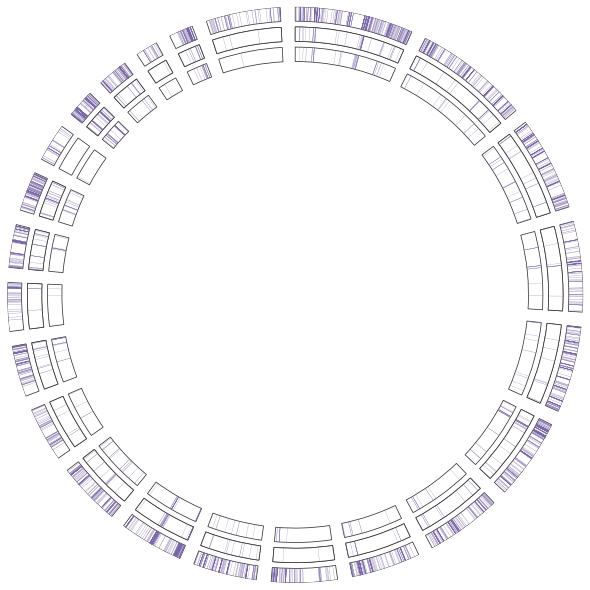

In [38]:
circle.figure

In [39]:
circle.figure.savefig('/project/GCRB/Hon_lab/s426305/Analysis/Spade_test/MB231/Jupyter_plots/circous_plot-local_cell_lines-v1.tiff', dpi=600)